Get Data

In [2]:
import opendatasets as od 
import pandas as pd
import numpy as np
import os

if not os.path.exists('steam-games-dataset'):
    od.download( 
        "https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data") 
    
if not os.path.exists('steam-video-games'):
    od.download( 
        "https://www.kaggle.com/datasets/tamber/steam-video-games/data") 
    
if not os.path.exists('popularity-of-games-on-steam'):
    od.download( 
        "https://www.kaggle.com/datasets/michau96/popularity-of-games-on-steam") 

Load Data

In [3]:
user_data = pd.read_csv('steam-video-games\steam-200k.csv', encoding='ISO-8859-1', usecols=[0, 1, 2, 3], names=['UserID', 'Game', 'Behavior', 'Quantity'])
# Note: Behvior is either purchase or play. When behavior is purchase, quantity is always 1. When behavior is play, quantity is the number of hours

Find average hours played per game

In [4]:
hours_played = user_data[user_data['Behavior'] == 'play'].groupby('Game').agg(np.mean).sort_values(by='Quantity', ascending=False).drop('UserID', axis='columns')
hours_played.head(20)

,Quantity
Game,
Eastside Hockey Manager,1295.000000
Baldur's Gate II Enhanced Edition,475.255556
FIFA Manager 09,411.000000
Perpetuum,400.975000
Football Manager 2014,391.984615
Football Manager 2012,390.453165
Football Manager 2010,375.048571
Football Manager 2011,365.703226
Freaking Meatbags,331.000000


Normalize play quantity

In [5]:
normalized_user_data = user_data.copy()[user_data['Game'].isin(hours_played.index)]
normalized_user_data['Quantity'] = normalized_user_data.apply(lambda x: x['Quantity'] if x['Behavior'] == 'purchase' else x['Quantity'] / hours_played.loc[x['Game'], :]['Quantity'], axis=1)
normalized_user_data.head(10)

,UserID,Game,Behavior,Quantity
0,151603712,The Elder Scrolls V Skyrim,purchase,1.000000
1,151603712,The Elder Scrolls V Skyrim,play,2.607178
2,151603712,Fallout 4,purchase,1.000000
3,151603712,Fallout 4,play,1.349928
4,151603712,Spore,purchase,1.000000
5,151603712,Spore,play,0.506387
6,151603712,Fallout New Vegas,purchase,1.000000
7,151603712,Fallout New Vegas,play,0.234121
8,151603712,Left 4 Dead 2,purchase,1.000000
9,151603712,Left 4 Dead 2,play,0.212190


Combine rows

In [6]:
grouped_users = normalized_user_data.groupby(['UserID', 'Game']).aggregate({'Quantity': 'sum'})
grouped_users = grouped_users.reset_index(level='Game')
grouped_users.loc[151603712]

,Game,Quantity
UserID,,
151603712,Alan Wake,1.000000
151603712,BioShock,1.065645
151603712,BioShock 2,1.000000
151603712,BioShock Infinite,1.074707
151603712,Dead Island Epidemic,1.239623
151603712,Dota 2,1.002466
151603712,Dragon Age Origins - Ultimate Edition,1.030049
151603712,Eldevin,1.021525
151603712,Fallen Earth,1.000000


Pivot long to wide

In [7]:
#pivoted_users = grouped_users.pivot(index='UserID', columns='Game', values='Quantity')
pivoted_users = grouped_users.reset_index()
pivoted_users = pivoted_users.set_index(['UserID', 'Game'])
pivoted_users = pivoted_users.unstack(fill_value=0)
pivoted_users.shape

(12369, 3600)

In [23]:
pivoted_users.dtypes

          Game                                                      
Quantity  007 Legends                                                   float64
          0RBITALIS                                                     float64
          1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)    float64
          10 Second Ninja                                               float64
          10,000,000                                                    float64
                                                                         ...   
          rymdkapsel                                                    float64
          sZone-Online                                                  float64
          the static speaks my name                                     float64
          theHunter                                                     float64
          theHunter Primal                                              float64
Length: 3600, dtype: object

Train test split

In [11]:
data = pivoted_users.sample(frac=1)
split_index = int(data.shape[0] * 0.8)
train = data[:split_index]
test = data[split_index:]

PCA

In [24]:
from sklearn.decomposition import PCA
# Cross val
var_ratio = []
for n in range(20, 301, 20):    
    pca_test = PCA(n_components=n).fit(train.values) #.values supresses warning about feature names
    var_ratio.append(np.sum(pca_test.explained_variance_ratio_))

Plot Variances

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

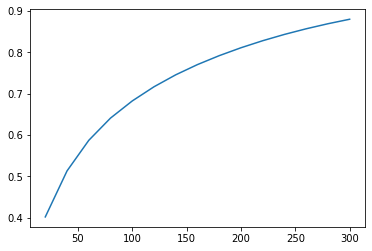

In [27]:
plt.plot(range(20, 301, 20), var_ratio)

In [58]:
pca = PCA(n_components=200)
train_pca = pca.fit_transform(train.values)

test_pca = pca.transform(test.values)

np.sum(pca.explained_variance_ratio_)

0.8108259137979048

Nearest Neighbors

In [59]:
from sklearn.neighbors import KDTree
tree = KDTree(train_pca) 

In [48]:
test.iloc[0].sort_values(ascending=False)[:10]

          Game                                
Quantity  Unturned                                1.451604
          007 Legends                             0.000000
          Ravensword Shadowlands                  0.000000
          Rayman Origins                          0.000000
          Razor2 Hidden Skies                     0.000000
          Reach for the Sun                       0.000000
          Real Boxing                             0.000000
          Real Horror Stories Ultimate Edition    0.000000
          Real Warfare                            0.000000
          Real World Racing                       0.000000
Name: 188991147, dtype: float64

In [60]:
neighbors = tree.query(test_pca[:1], k=10, return_distance=False)
neighbors

array([[2030, 7777, 4123, 4480, 7665, 8302, 2455, 3118, 2490, 2021]],
      dtype=int64)

In [62]:
for neighbor in neighbors[0]:
    print(train.iloc[neighbor].sort_values(ascending=False)[:10])

          Game                                
Quantity  Unturned                                1.444963
          007 Legends                             0.000000
          Ravensword Shadowlands                  0.000000
          Rayman Origins                          0.000000
          Razor2 Hidden Skies                     0.000000
          Reach for the Sun                       0.000000
          Real Boxing                             0.000000
          Real Horror Stories Ultimate Edition    0.000000
          Real Warfare                            0.000000
          Real World Racing                       0.000000
Name: 236370333, dtype: float64
          Game                                
Quantity  Unturned                                1.438322
          007 Legends                             0.000000
          Ravensword Shadowlands                  0.000000
          Rayman Origins                          0.000000
          Razor2 Hidden Skies                   